<a href="https://colab.research.google.com/github/a-forty-two/EY_batch11_3Mar/blob/main/7Mar_001_Pooling_and_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

Let's begin with some random data

In [15]:
temp = [ 0., 1., 1., 0., 0.,2., 1., 1., 0., 3.]
values = tf.reshape(temp, [1,1,2,5])

In [16]:
temp

[0.0, 1.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, 3.0]

In [17]:
values

<tf.Tensor: shape=(1, 1, 2, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 0., 0.],
         [2., 1., 1., 0., 3.]]]], dtype=float32)>

Pooling combines a set of inputs as a unit before applying the transformation. The two most common types are:

In [18]:
avgpool = tf.nn.pool(input=values, window_shape=(1,2),
                     pooling_type='AVG', padding='VALID')
maxpool = tf.nn.pool(input=values, window_shape=(1,2),
                     pooling_type='MAX', padding='VALID')

This will roll over our data in the window sizes of (1,2)

For example, the first window of (1,2) selects the 0th elements of the two inner tensors, yielding 0 and 2. The average of 0 and 2 is 1, and the max is 2.
<br/>
The next window will be (1,1). Their average is 1, and max is also 1.
<br/>
The last window is (0,3), with the average as 0.5, and max value as 3.

In [19]:
values

<tf.Tensor: shape=(1, 1, 2, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 0., 0.],
         [2., 1., 1., 0., 3.]]]], dtype=float32)>

In [20]:
avgpool

<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[1. , 1. , 1. , 0. , 1.5]]]], dtype=float32)>

In [6]:
maxpool

<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[2., 1., 1., 0., 3.]]]], dtype=float32)>

**Convolutions**

Convolutions help us generate feature maps for the input data. The sequential placing of convolutions generates very complex feature maps, which are then used for training.

Thanks to convolutions, we can detect various shapes and boundaries.

Consider following image set i1, i2 and i3

In [7]:
i1 = np.array([np.array([200,200]),np.array([0,0])]) # HORIZONTAL
i2 = np.array([np.array([200,0]),np.array([200,0])]) # vertical
i3 = np.array([np.array([200,0]),np.array([0,200])]) #diagonal


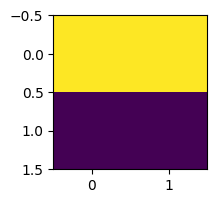

In [8]:
plt.figure(figsize=(2,2))
plt.imshow(i1)

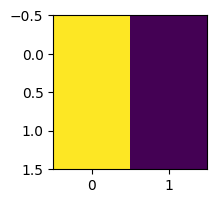

In [9]:
plt.figure(figsize=(2,2))
plt.imshow(i2)

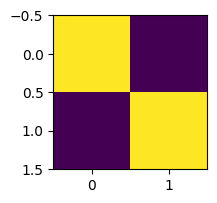

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(i3)

Now let's design 3 kernels, that we will use to detect if any of these images have a horizontal, vertical or diagonal boundaries.

In [11]:
kernels_h =np.array([np.array([2,2]),np.array([-2,-2])])
kernels_v=np.array([np.array([2,-2]),np.array([2,-2])])
kernels_d=np.array([np.array([2,-2]),np.array([-2,2])])

kernels are very similar to weights- instead of <br/><br/>
y = weights * inputs + bias
<br/><br/>
we will use<br/><br/>
y = kernels * input + bias
<br/><br/>
Let's build a function to do this for us.

In [12]:
def applyKernel(img, kernel):
  result = np.sum(np.multiply(img, kernel))
  return result

In [13]:
detect = lambda val: ' detected' if val>0 else ' not detected'
kernels = [kernels_h, kernels_v, kernels_d]
kernel_names = ['horizontal', 'vertical','diagonal']
images = [i1, i2, i3]

for count, img in enumerate(images):
  print('Image number ' + str(count+1), end=' ,')
  for counter, kernel in enumerate(kernels):
    print('Kernel ' + kernel_names[counter], end=': ')
    print(detect( applyKernel(img, kernel) ))



Image number 1 ,Kernel horizontal:  detected
Kernel vertical:  not detected
Kernel diagonal:  not detected
Image number 2 ,Kernel horizontal:  not detected
Kernel vertical:  detected
Kernel diagonal:  not detected
Image number 3 ,Kernel horizontal:  not detected
Kernel vertical:  not detected
Kernel diagonal:  detected


With the fundamentals right, let's observe convolutional kernels inside some of the pretrained models.

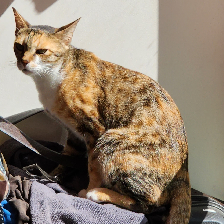

In [25]:
from keras.utils import load_img
data = load_img('cat.jpg', target_size=(224,224))

#Ignore the GPU warnings
data

Load a pretrained model

In [26]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16()


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


Extract weights and bias from this model

In [27]:
kernels, biases = model.layers[1].get_weights()

Normalize the filters (for ease of plotting and view)

In [28]:
filtermin, filtermax = kernels.min(), kernels.max()
normfilters = (kernels- filtermin) / (filtermax -  filtermin)  # (x-min)/(max-min)


Look at the filters

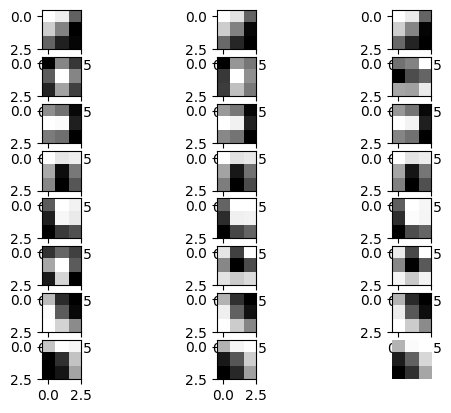

In [29]:

n_filters_rows, ix = 8, 1
n_filters_col = 3
# 24 filters-> 8 X 3
for i in range(n_filters_rows):
  kernel = kernels[:,:,:,i]
  for j in range(n_filters_col):
    ax = plt.subplot(n_filters_rows, n_filters_col, ix)
    plt.imshow(kernel[:,:,j], cmap='gray')
    ix = ix+1

plt.axis('off')
plt.show()

**Transfer Learning**

We can reuse some of this VGG16 network! In order to do that, we will need to chop the layers and create a new model.

First, look at what we are about to slice and dice- the first 15 layers maybe



In [30]:
brk = 1
for layer in model.layers:
  print(layer.name)
  if 'conv' in layer.name:
    kernels, biases = layer.get_weights()
    print(kernels.shape)
  brk += 1
  if brk==15:
    break

input_layer
block1_conv1
(3, 3, 3, 64)
block1_conv2
(3, 3, 64, 64)
block1_pool
block2_conv1
(3, 3, 64, 128)
block2_conv2
(3, 3, 128, 128)
block2_pool
block3_conv1
(3, 3, 128, 256)
block3_conv2
(3, 3, 256, 256)
block3_conv3
(3, 3, 256, 256)
block3_pool
block4_conv1
(3, 3, 256, 512)
block4_conv2
(3, 3, 512, 512)
block4_conv3
(3, 3, 512, 512)


Observe how convolutions are frequently pooled before being convoluted again!

Let's slice the model till the 4th layer

In [31]:
from tensorflow.keras import Model
newmodel = Model(inputs= model.inputs, outputs= model.layers[3].output)


In [35]:
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input
from keras.utils import load_img, img_to_array
img = load_img('cat.jpg', target_size=(224,224))
img = img_to_array(img)
img.shape

(224, 224, 3)

Let's observe the feature maps generated through the kernels.

In [36]:
image = expand_dims(img, axis=0)
image = preprocess_input(image)
featureMaps = newmodel.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Let's look at the convolutions!

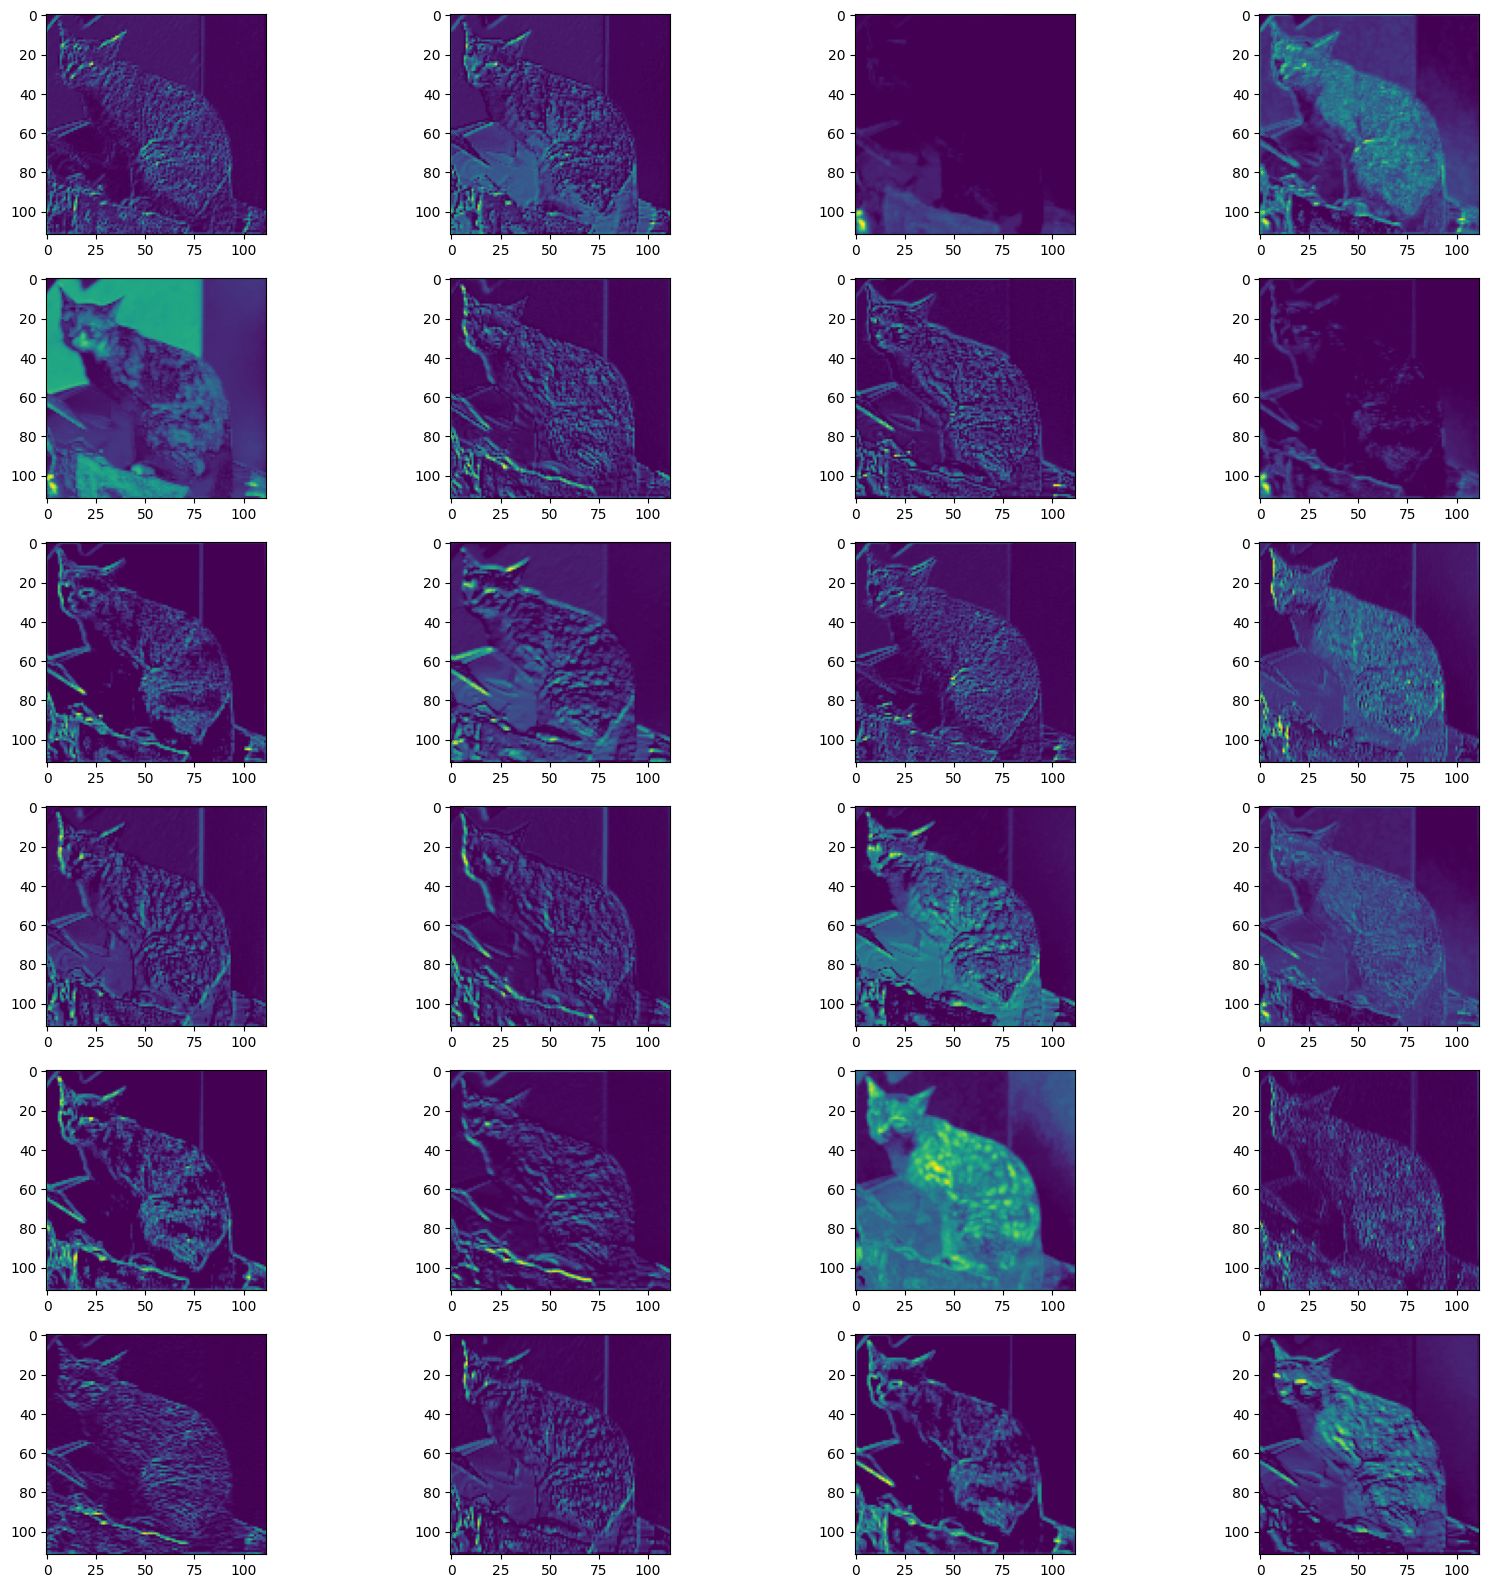

In [37]:
ix = 1
plt.figure(figsize=(20,20))
for x in range(24):
  ax = plt.subplot(6,4, ix )
  plt.imshow(featureMaps[0,:,:,ix-1])
  ix = ix +1
plt.show()

Can you spot the cat?